In [2]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Set CUDA_LAUNCH_BLOCKING environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

class change_detection_dataset(Dataset):
    def __init__(self,root_path) -> None:
        super().__init__()
        self.pre_change_path=os.path.join(root_path,"A")
        self.post_change_path=os.path.join(root_path,"B")
        self.change_label_path=os.path.join(root_path,"label")
        self.fname_list=os.listdir(self.pre_change_path)
    def __getitem__(self, index):
        fname=self.fname_list[index]
        pre_img=Image.open(os.path.join(self.pre_change_path,fname)).convert("RGB")
        post_img=Image.open(os.path.join(self.post_change_path,fname)).convert("RGB")
        change_label=Image.open(os.path.join(self.change_label_path,fname)).convert("1")
        transform=transforms.Compose([
            transforms.ToTensor()
        ])
        pre_tensor=transform(pre_img)
        post_tensor=transform(post_img)
        label_tensor=transform(change_label)
        return {'pre':pre_tensor,'post':post_tensor,'label':label_tensor,'fname':fname}
    def __len__(self):
        return len(self.fname_list)


In [3]:
train_path="D:\\Datasets\\Levir_croped_256\\LEVIR_CD\\train"
test_path="D:\\Datasets\\Levir_croped_256\\LEVIR_CD\\test"
val_path="D:\\Datasets\\Levir_croped_256\\LEVIR_CD\\val"

if __name__=="__main__":
    train_loader=DataLoader(change_detection_dataset(root_path=train_path),batch_size=8,shuffle=True,num_workers=0,pin_memory=False)
    test_loader=DataLoader(change_detection_dataset(root_path=test_path),batch_size=4,shuffle=False,num_workers=0,pin_memory=False)
    val_loader=DataLoader(change_detection_dataset(root_path=val_path),batch_size=4,shuffle=False,num_workers=0,pin_memory=False)

pre_tensor.shape=torch.Size([8, 3, 256, 256])
post_tensor.shape=torch.Size([8, 3, 256, 256])
label_tensor.shape=torch.Size([8, 1, 256, 256])
fname=train_4_14.png


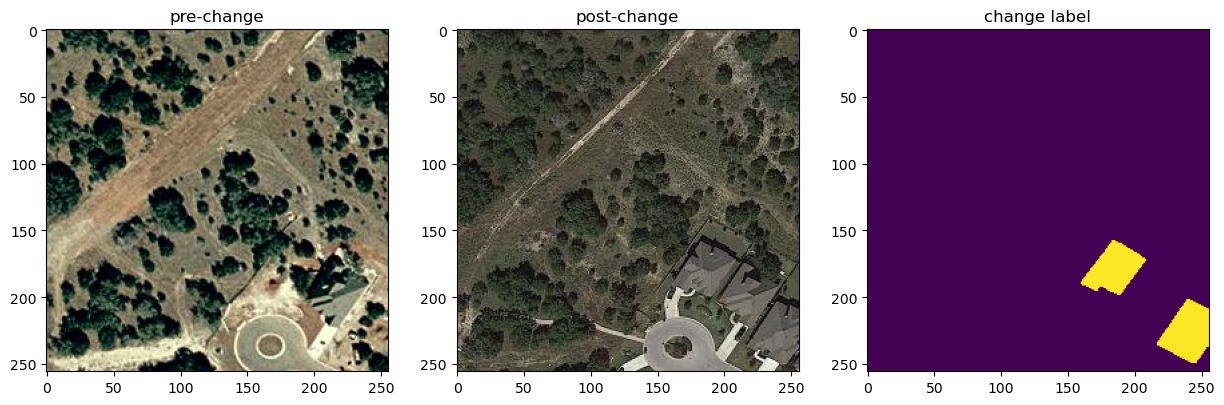

In [5]:
for i, data in enumerate(train_loader):
        pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
        fig=plt.figure(figsize=(15,5))
        print (f'pre_tensor.shape={pre_tensor.shape}')
        print (f'post_tensor.shape={post_tensor.shape}')
        print (f'label_tensor.shape={label_tensor.shape}')
        

        preplot=fig.add_subplot(131)
        preplot.imshow(pre_tensor[1,:,:,:].permute(1,2,0).numpy())
        preplot.set_title("pre-change")

        postplot=fig.add_subplot(132)
        postplot.set_title("post-change")
        postplot.imshow(post_tensor[1,:,:,:].permute(1,2,0).numpy())

        labelplot=fig.add_subplot(133)
        labelplot.set_title("change label")
        labelplot.imshow(label_tensor[1,:,:,:].permute(1,2,0).numpy())
        # transforms.ToPILImage()(pre_tensor[0,:,:,:])
        # transforms.ToPILImage()(post_tensor[0,:,:,:])
        # transforms.ToPILImage()(label_tensor[0,:,:,:])
        print(f'fname={fname[0]}')
        break

In [85]:
################# Seeding the randomness  #################
import random

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
import torch
import torch.nn as nn

class conv_block_nested(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch, device=None):
        super(conv_block_nested, self).__init__()
        self.device = device

        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True, device=device)
        self.bn1 = nn.BatchNorm2d(mid_ch, device=device)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True, device=device)
        self.bn2 = nn.BatchNorm2d(out_ch, device=device)

    def forward(self, x):
        x = self.conv1(x)
        identity = x      #1, 16, 256, 256
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)   # 1, 16, 256, 256
        
        output = self.activation(x + identity)
        return output    #1, 16, 256, 256

In [7]:
################### Test the conv_block_nested ###################
# seeding(45)

x = torch.randn(1, 3, 256, 256)

conv_block_nested_test = conv_block_nested(3, 16, 16)
out = conv_block_nested_test(x)
print(out.shape)

torch.Size([1, 16, 256, 256])


In [8]:
class up(nn.Module):
    def __init__(self, in_ch, bilinear=False, device=None):
        super(up, self).__init__()
        self.device = device

        if bilinear:
            self.up = nn.Upsample(scale_factor=2,
                                  mode='bilinear',
                                  align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, 2, stride=2, device=device)

    def forward(self, x):

        x = self.up(x)
        return x


In [9]:
################### Test the up ###################
x = torch.randn(1, 3, 16, 16)

up_test = up(3)
out = up_test(x)
print(out.shape)


torch.Size([1, 3, 32, 32])


In [10]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio = 16, device=None):
        super(ChannelAttention, self).__init__()
        self.device = device
        self.avg_pool = nn.AdaptiveAvgPool2d(1)   #reduces spatial dimensions (h and w) of input feature map to 1x1
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        #### MLP:
        self.fc1 = nn.Conv2d(in_channels,in_channels//ratio, 1, bias=False, device=device)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels//ratio, in_channels, 1, bias=False, device=device)
        self.sigmod = nn.Sigmoid()
    
    def forward(self,x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmod(out)

In [11]:
########### Test the ChannelAttention ###########
# seeding(45)

x = torch.randn(1, 32, 16, 16)
out = ChannelAttention(32)(x)

out = out*x 
print(out.shape)


torch.Size([1, 32, 16, 16])


In [12]:
class SNUNet_ECAM(nn.Module):
    # SNUNet-CD with ECAM
    def __init__(self, in_ch=3, out_ch=1, device=None):                            # In original paper, in_ch=3, out_ch=2 (not 1)
        super(SNUNet_ECAM, self).__init__()
        self.device = device
        # torch.nn.Module.dump_patches = True

        n1 = 32     # the initial number of channels of feature map
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0], device=device)
        
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1], device=device)
        self.Up1_0 = up(filters[1], device=device)
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2] , device=device)
        self.Up2_0 = up(filters[2], device=device)
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3], device=device)
        self.Up3_0 = up(filters[3], device=device)
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4], device=device)
        self.Up4_0 = up(filters[4], device=device)

        self.conv0_1 = conv_block_nested(filters[0] * 2 + filters[1], filters[0], filters[0], device=device)
        self.conv1_1 = conv_block_nested(filters[1] * 2 + filters[2], filters[1], filters[1], device=device)
        self.Up1_1 = up(filters[1], device=device)
        self.conv2_1 = conv_block_nested(filters[2] * 2 + filters[3], filters[2], filters[2], device=device)
        self.Up2_1 = up(filters[2], device=device)
        self.conv3_1 = conv_block_nested(filters[3] * 2 + filters[4], filters[3], filters[3], device=device)
        self.Up3_1 = up(filters[3], device=device)

        self.conv0_2 = conv_block_nested(filters[0] * 3 + filters[1], filters[0], filters[0], device=device)
        self.conv1_2 = conv_block_nested(filters[1] * 3 + filters[2], filters[1], filters[1], device=device)
        self.Up1_2 = up(filters[1], device=device)
        self.conv2_2 = conv_block_nested(filters[2] * 3 + filters[3], filters[2], filters[2], device=device)
        self.Up2_2 = up(filters[2], device=device)

        self.conv0_3 = conv_block_nested(filters[0] * 4 + filters[1], filters[0], filters[0], device=device)
        self.conv1_3 = conv_block_nested(filters[1] * 4 + filters[2], filters[1], filters[1], device=device)
        self.Up1_3 = up(filters[1], device=device)

        self.conv0_4 = conv_block_nested(filters[0] * 5 + filters[1], filters[0], filters[0], device=device)

        self.ca = ChannelAttention(filters[0] * 4, ratio=16, device=device)
        self.ca1 = ChannelAttention(filters[0], ratio=16 // 4, device=device)

        self.conv_final = nn.Conv2d(filters[0] * 4, out_ch, kernel_size=1, device=device)
        self.sigmoid = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def forward(self, xA, xB):
        print ("xA shape is: ", xA.shape)
        print ("xB shape is: ", xB.shape)
        '''xA'''
        x0_0A = self.conv0_0(xA)
        print ("x0_0A shape is: ", x0_0A.shape)
        x1_0A = self.conv1_0(self.pool(x0_0A))
        x2_0A = self.conv2_0(self.pool(x1_0A))
        x3_0A = self.conv3_0(self.pool(x2_0A))
        # x4_0A = self.conv4_0(self.pool(x3_0A))
        '''xB'''
        x0_0B = self.conv0_0(xB)
        print ("x0_0B shape is: ", x0_0B.shape)
        x1_0B = self.conv1_0(self.pool(x0_0B))
        x2_0B = self.conv2_0(self.pool(x1_0B))
        x3_0B = self.conv3_0(self.pool(x2_0B))
        x4_0B = self.conv4_0(self.pool(x3_0B))

        x0_1 = self.conv0_1(torch.cat([x0_0A, x0_0B, self.Up1_0(x1_0B)], 1))                   #1, 32, 256, 256
        # print ("x0_1 shape is: ", x0_1.shape)
        x1_1 = self.conv1_1(torch.cat([x1_0A, x1_0B, self.Up2_0(x2_0B)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0A, x0_0B, x0_1, self.Up1_1(x1_1)], 1))              #1, 32, 256, 256
        # print ("x0_2 shape is: ", x0_2.shape)

        x2_1 = self.conv2_1(torch.cat([x2_0A, x2_0B, self.Up3_0(x3_0B)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0A, x1_0B, x1_1, self.Up2_1(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0A, x0_0B, x0_1, x0_2, self.Up1_2(x1_2)], 1))        #1, 32, 256, 256
        # print ("x0_3 shape is: ", x0_3.shape)
        x3_1 = self.conv3_1(torch.cat([x3_0A, x3_0B, self.Up4_0(x4_0B)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0A, x2_0B, x2_1, self.Up3_1(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0A, x1_0B, x1_1, x1_2, self.Up2_2(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0A, x0_0B, x0_1, x0_2, x0_3, self.Up1_3(x1_3)], 1))  #1, 32, 256, 256
        # print ("x0_4 shape is: ", x0_4.shape) 
        
        out = torch.cat([x0_1, x0_2, x0_3, x0_4], 1)        # one tensor ## 1, 128, 256, 256
        # print ("out shape is: ", out.shape)

        intra = torch.sum(torch.stack((x0_1, x0_2, x0_3, x0_4)), dim=0)  # [[x0_1],[x0_2],[x0_3],[x0_4]] the we sum these tensors
        # print ("intra shape is: ", intra.shape)                          ## 1, 32, 256, 256

        ca1 = self.ca1(intra)
        out = self.ca(out) * (out + ca1.repeat(1, 4, 1, 1))             # 1, 128, 256, 256
        # print ("out shape is: ", out.shape)
        out = self.conv_final(out)                                      # 1, 1, 256, 256
        print ("out shape is: ", out.shape)   
        out = self.sigmoid(out)

        return (out)
    


In [97]:
############ Understanding repeat function ############
tensor = torch.randn([1, 3, 256, 256])
repeated_tensor = tensor.repeat(1,4, 1, 1)

print("Original Tensor:")
print(tensor.shape)
print("Repeated Tensor:")
print (repeated_tensor.shape)

Original Tensor:
torch.Size([1, 3, 256, 256])
Repeated Tensor:
torch.Size([1, 12, 256, 256])


In [13]:
################### Test the SNUNet_ECAM ###################
# seeding(45)

xA = torch.randn(8, 3, 256, 256)
xB = torch.randn(8, 3, 256, 256)

model = SNUNet_ECAM()
out = model(xA, xB)
print(out.shape)


xA shape is:  torch.Size([8, 3, 256, 256])
xB shape is:  torch.Size([8, 3, 256, 256])
x0_0A shape is:  torch.Size([8, 32, 256, 256])
x0_0B shape is:  torch.Size([8, 32, 256, 256])
out shape is:  torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


In [14]:
def train(model, train_loader, val_loader, optimizer, loss_function, device, num_epochs, save_path):
    for epoch in range(num_epochs):
        loss_list=[]
        model.train()
        for _, data in enumerate(train_loader):
            optimizer.zero_grad()
            pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
            print ("pre_tensor shape is: ", pre_tensor.shape)
            print ("post_tensor shape is: ", post_tensor.shape)
            print ("label_tensor shape is: ", label_tensor.shape)
            pre_tensor = pre_tensor.to(device)
            post_tensor = post_tensor.to(device)
            label_tensor = label_tensor.to(device)
            prediction = model(pre_tensor, post_tensor)
            total_loss=loss_function(prediction,label_tensor)
            loss_list.append(total_loss.item()) #only append the loss value and ignore the grad to save memory
            total_loss.backward()
            optimizer.step()
        loss_avg=sum(loss_list)/len(loss_list)
        print(f'Epoch {epoch} training completed, the average loss is {loss_avg}.')

        if (epoch+1) % 10==0:
            model.eval()
            OA_list=[]
            for _, data in enumerate(val_loader):
                pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
                pre_tensor = pre_tensor.to(device)
                post_tensor = post_tensor.to(device)
                label_tensor = label_tensor.to(device)
                probs = model(pre_tensor, post_tensor)
                prediction = torch.where(probs>0.5,1,0)
                true_count=torch.sum(prediction==label_tensor)
                OA=true_count/prediction.numel()
                OA_list.append(OA)
            print("*"*10)
            print(f'Epoch {epoch} evaluation completed, the average OA is {sum(OA_list)/len(OA_list)}')
            print("*"*10)
            torch.save(model.state_dict(),os.path.join(save_path,"ResUnet"+str(epoch)+".pth"))

In [15]:
# Example of adding shape checks
for _,data in enumerate(train_loader):
    pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
    print(f"pre_tensor shape: {pre_tensor.shape}, post_tensor shape: {post_tensor.shape}",label_tensor.shape)
    break  # Remove this break to check all batches

pre_tensor shape: torch.Size([8, 3, 256, 256]), post_tensor shape: torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])


In [16]:
import os

# Set CUDA_LAUNCH_BLOCKING environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"


print(device)
model = SNUNet_ECAM()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.BCELoss()
num_epochs = 30
save_path = "E://VS Projects//test_13-2-2025_SNUNET-CD//checkpoint1"
os.makedirs(save_path, exist_ok=True)
train(model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs=num_epochs, save_path=save_path)

cuda
pre_tensor shape is:  torch.Size([8, 3, 256, 256])
post_tensor shape is:  torch.Size([8, 3, 256, 256])
label_tensor shape is:  torch.Size([8, 1, 256, 256])
xA shape is:  torch.Size([8, 3, 256, 256])
xB shape is:  torch.Size([8, 3, 256, 256])
x0_0A shape is:  torch.Size([8, 32, 256, 256])
x0_0B shape is:  torch.Size([8, 32, 256, 256])
out shape is:  torch.Size([8, 1, 256, 256])
pre_tensor shape is:  torch.Size([8, 3, 256, 256])
post_tensor shape is:  torch.Size([8, 3, 256, 256])
label_tensor shape is:  torch.Size([8, 1, 256, 256])
xA shape is:  torch.Size([8, 3, 256, 256])
xB shape is:  torch.Size([8, 3, 256, 256])
x0_0A shape is:  torch.Size([8, 32, 256, 256])
x0_0B shape is:  torch.Size([8, 32, 256, 256])
out shape is:  torch.Size([8, 1, 256, 256])
pre_tensor shape is:  torch.Size([8, 3, 256, 256])
post_tensor shape is:  torch.Size([8, 3, 256, 256])
label_tensor shape is:  torch.Size([8, 1, 256, 256])
xA shape is:  torch.Size([8, 3, 256, 256])
xB shape is:  torch.Size([8, 3, 256,

In [17]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [19]:
from torchvision.utils import save_image

model = SNUNet_ECAM()
model=model.to(device)
model.load_state_dict(torch.load("E://VS Projects//test_13-2-2025_SNUNET-CD//checkpoint1//ResUnet29.pth"))

test_results_path="E://VS Projects//test_13-2-2025_SNUNET-CD//test_results1"
os.makedirs(test_results_path,exist_ok=True)
TP=0
TN=0
FP=0
FN=0
for _, data in enumerate(test_loader):
    pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
    pre_tensor = pre_tensor.to(device)
    post_tensor = post_tensor.to(device)
    label_tensor = label_tensor.to(device)
    probs = model(pre_tensor, post_tensor)
    prediction = torch.where(probs>0.5,1.0,0.0)
    true_positives, false_positives, true_negatives, false_negatives = confusion(prediction,label_tensor)
    TP+=true_positives
    TN+=true_negatives
    FP+=false_positives
    FN+=false_negatives
    for i in range(prediction.shape[0]):
        save_image(prediction[i,:,:,:].cpu(), os.path.join(test_results_path, fname[i]))

C:\Users\G7\AppData\Local\Temp\ipykernel_12484\3111922588.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("E://VS Projects//test_13-2-20

xA shape is:  torch.Size([4, 3, 256, 256])
xB shape is:  torch.Size([4, 3, 256, 256])
x0_0A shape is:  torch.Size([4, 32, 256, 256])
x0_0B shape is:  torch.Size([4, 32, 256, 256])
out shape is:  torch.Size([4, 1, 256, 256])
xA shape is:  torch.Size([4, 3, 256, 256])
xB shape is:  torch.Size([4, 3, 256, 256])
x0_0A shape is:  torch.Size([4, 32, 256, 256])
x0_0B shape is:  torch.Size([4, 32, 256, 256])
out shape is:  torch.Size([4, 1, 256, 256])
xA shape is:  torch.Size([4, 3, 256, 256])
xB shape is:  torch.Size([4, 3, 256, 256])
x0_0A shape is:  torch.Size([4, 32, 256, 256])
x0_0B shape is:  torch.Size([4, 32, 256, 256])
out shape is:  torch.Size([4, 1, 256, 256])
xA shape is:  torch.Size([4, 3, 256, 256])
xB shape is:  torch.Size([4, 3, 256, 256])
x0_0A shape is:  torch.Size([4, 32, 256, 256])
x0_0B shape is:  torch.Size([4, 32, 256, 256])
out shape is:  torch.Size([4, 1, 256, 256])
xA shape is:  torch.Size([4, 3, 256, 256])
xB shape is:  torch.Size([4, 3, 256, 256])
x0_0A shape is:  t

fname=test_8_6.png


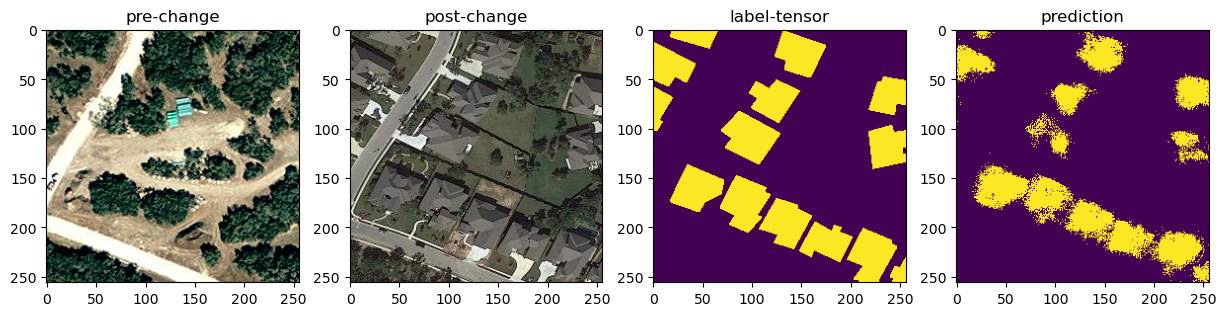

In [20]:
import matplotlib.pyplot as plt
import numpy as np

pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
fig=plt.figure(figsize=(15,5))

preplot=fig.add_subplot(141)
preplot.imshow(pre_tensor[1,:,:,:].permute(1,2,0).numpy())
preplot.set_title("pre-change")

postplot=fig.add_subplot(142)
postplot.set_title("post-change")
postplot.imshow(post_tensor[1,:,:,:].permute(1,2,0).numpy())

postplot=fig.add_subplot(143)
postplot.set_title("label-tensor")
postplot.imshow(label_tensor[1,:,:,:].permute(1,2,0).numpy())

labelplot=fig.add_subplot(144)
labelplot.set_title("prediction")
labelplot.imshow(prediction[1,:,:,:].permute(1,2,0).cpu().numpy())
# transforms.ToPILImage()(pre_tensor[0,:,:,:])
# transforms.ToPILImage()(post_tensor[0,:,:,:])
# transforms.ToPILImage()(label_tensor[0,:,:,:])
print(f'fname={fname[0]}')

In [21]:
OA=(TP+TN)/(TP+TN+FP+FN)
Precision=TP/(TP+FP)
Recall=TP/(TP+FN)
F1_score=2*Precision*Recall/(Precision+Recall)

print(f'OA={OA:.3f}, Precision={Precision:.3f}, Recall={Recall:.3f}, F1-score={F1_score:.3f}')

OA=0.983, Precision=0.832, Recall=0.664, F1-score=0.738


In [22]:
import torchinfo
torchinfo.summary(model, input_size=[(8,3,256,256),(8,3,256,256)], device=device)

xA shape is:  torch.Size([8, 3, 256, 256])
xB shape is:  torch.Size([8, 3, 256, 256])
x0_0A shape is:  torch.Size([8, 32, 256, 256])
x0_0B shape is:  torch.Size([8, 32, 256, 256])
out shape is:  torch.Size([8, 1, 256, 256])


Layer (type:depth-idx)                   Output Shape              Param #
SNUNet_ECAM                              [8, 1, 256, 256]          --
├─conv_block_nested: 1-1                 [8, 32, 256, 256]         --
│    └─Conv2d: 2-1                       [8, 32, 256, 256]         896
│    └─BatchNorm2d: 2-2                  [8, 32, 256, 256]         64
│    └─ReLU: 2-3                         [8, 32, 256, 256]         --
│    └─Conv2d: 2-4                       [8, 32, 256, 256]         9,248
│    └─BatchNorm2d: 2-5                  [8, 32, 256, 256]         64
│    └─ReLU: 2-6                         [8, 32, 256, 256]         --
├─MaxPool2d: 1-2                         [8, 32, 128, 128]         --
├─conv_block_nested: 1-3                 [8, 64, 128, 128]         --
│    └─Conv2d: 2-7                       [8, 64, 128, 128]         18,496
│    └─BatchNorm2d: 2-8                  [8, 64, 128, 128]         128
│    └─ReLU: 2-9                         [8, 64, 128, 128]         --
│    └